# Modelo de Árbol de Decisión - Rendimiento Académico

En este cuaderno se va a desarrollar un modelo de **árbol de decisión** que permite predecir el **rendimiento académico** de un estudiante, basándose en características como:

- Horas de estudio
- Calificaciones anteriores
- Actividades extraescolares
- Horas de sueño
- Ejercicios prácticos realizados

A diferencia de modelos como la regresión lineal, los árboles de decisión permiten hacer predicciones de forma visual y sencilla, ramificando decisiones según condiciones en los datos. Son especialmente útiles cuando se busca interpretar **por qué** se llega a una predicción, ya que cada nodo representa una decisión lógica.

**Objetivo:** Se busca clasificar a los estudiantes entre *rendimiento alto* (`≥ 70`) o *rendimiento bajo*, construyendo un árbol que siga reglas derivadas directamente de los datos.

**Hipótesis:** Se cree que variables como las **notas anteriores**, las **horas de estudio** y los **hábitos de preparación** influyen de forma significativa en el rendimiento académico final.

## Importación de librerías

A continuación se importan todas las librerías necesarias:

- `pandas` y `numpy` para tratamiento de datos
- `seaborn` y `matplotlib` para visualizaciones
- `sklearn` para construir el modelo y evaluarlo
- `ydata_profiling` para hacer un análisis exploratorio automático

In [10]:
# Se importan todas las librerías necesarias para trabajar con datos, visualizar y entrenar el árbol

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, classification_report


## 1. Carga y preparación inicial de los datos

Lo primero que se realiza es la carga del dataset original. Para facilitar el análisis, se renombran algunas columnas al español, manteniendo una estructura más clara. También se crea una columna adicional que transformará el rendimiento numérico en una variable **binaria**:

- `1`: si el estudiante tiene rendimiento alto (nota ≥ 70)
- `0`: si su rendimiento es bajo

In [2]:
# Se carga el archivo CSV con los datos académicos
df = pd.read_csv("Student_Performance.csv")

# Se renombran las columnas para trabajar en español
df = df.rename(columns={
    "Hours Studied": "Horas_Estudio",
    "Previous Scores": "Notas_Anteriores",
    "Extracurricular Activities": "Actividades_Extraescolares",
    "Sleep Hours": "Horas_Sueno",
    "Sample Question Papers Practiced": "Ejercicios_Practica",
    "Performance Index": "Rendimiento_Academico"
})

# Se crea una nueva columna binaria según el umbral de 70 puntos
df["Rendimiento_Alto"] = np.where(df["Rendimiento_Academico"] >= 70, 1, 0)

# Se muestra una vista previa de los primeros registros
df.head()

,Horas_Estudio,Notas_Anteriores,Actividades_Extraescolares,Horas_Sueno,Ejercicios_Practica,Rendimiento_Academico,Rendimiento_Alto
0,7,99,Yes,9,1,91.0,1
1,4,82,No,4,2,65.0,0
2,8,51,Yes,7,2,45.0,0
3,5,52,Yes,5,2,36.0,0
4,7,75,No,8,5,66.0,0


## 2. Análisis Exploratorio de los Datos (EDA)

Antes de construir el modelo, se explora el contenido del dataset para conocer su estructura. Se revisa:

- La cantidad de registros
- Los tipos de datos
- La distribución de la variable objetivo `Rendimiento_Alto`

Esta información permite tener una idea de cómo están equilibradas las clases y si hace falta realizar algún ajuste adicional.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Horas_Estudio                   10000 non-null  int64  
 1   Notas_Anteriores                10000 non-null  int64  
 2   Actividades_Extraescolares      10000 non-null  object 
 3   Horas_Sueno                     10000 non-null  int64  
 4   Ejercicios_Practica             10000 non-null  int64  
 5   Rendimiento_Academico           10000 non-null  float64
 6   Rendimiento_Alto                10000 non-null  int64  
 7   Actividades_Extraescolares_Bin  10000 non-null  int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 625.1+ KB
None


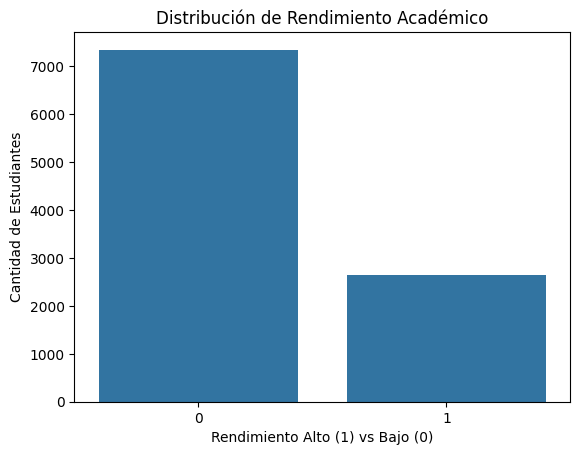

Render HTML: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


In [12]:
# Se muestra información general del dataframe
print(df.info())

# Se visualiza la distribución entre estudiantes de alto y bajo rendimiento
sns.countplot(x="Rendimiento_Alto", data=df)
plt.title("Distribución de Rendimiento Académico")
plt.xlabel("Rendimiento Alto (1) vs Bajo (0)")
plt.ylabel("Cantidad de Estudiantes")
plt.show()

# Se crea el informe automático
informe = ProfileReport(df, title="Informe Exploratorio - Rendimiento Académico", explorative=True)

# Se muestra el informe dentro del cuaderno (en Jupyter Notebook o VS Code)
informe.to_notebook_iframe()


## 3. Preprocesamiento y selección de variables

En este paso se transforma la variable categórica `Actividades_Extraescolares` a un valor binario (1 para "Yes", 0 para "No") ya que los algoritmos de aprendizaje automático requieren datos numéricos para trabajar.

Después, se seleccionan las variables predictoras (X) y la variable objetivo (y) para el modelo.

In [4]:
# Se transforma la variable categórica a binaria
df["Actividades_Extraescolares_Bin"] = df["Actividades_Extraescolares"].map({"Yes": 1, "No": 0})

# Se definen las variables predictoras y la variable objetivo
X = df[["Horas_Estudio", "Notas_Anteriores", "Actividades_Extraescolares_Bin",
        "Horas_Sueno", "Ejercicios_Practica"]]
y = df["Rendimiento_Alto"]

## 4. División del conjunto de datos

Se separan los datos en dos subconjuntos:

- **80% para entrenamiento** del modelo
- **20% para prueba**, para evaluar qué tan bien generaliza el modelo con datos nuevos

Esta división asegura que las métricas obtenidas reflejen el desempeño real del árbol.

In [5]:
# Se separan los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 5. Construcción y entrenamiento del árbol

Ahora que se tienen las variables preparadas, se crea un modelo de **árbol de decisión** usando la clase `DecisionTreeClassifier`.

Se limita la **profundidad máxima del árbol** a 4 niveles para evitar sobreajuste (overfitting) y hacerlo más fácil de interpretar visualmente.

In [6]:
# Se inicializa el árbol con profundidad máxima de 4
modelo_arbol = DecisionTreeClassifier(max_depth=4, random_state=42)

# Se entrena el modelo con los datos
modelo_arbol.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,4
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


## 6. Visualización del árbol de decisión

Una de las principales ventajas de este modelo es que se puede **visualizar** fácilmente cómo se toman las decisiones.

Cada nodo muestra una condición, y en cada bifurcación se indica cuántos datos cumplen la condición y a qué clase tienden.

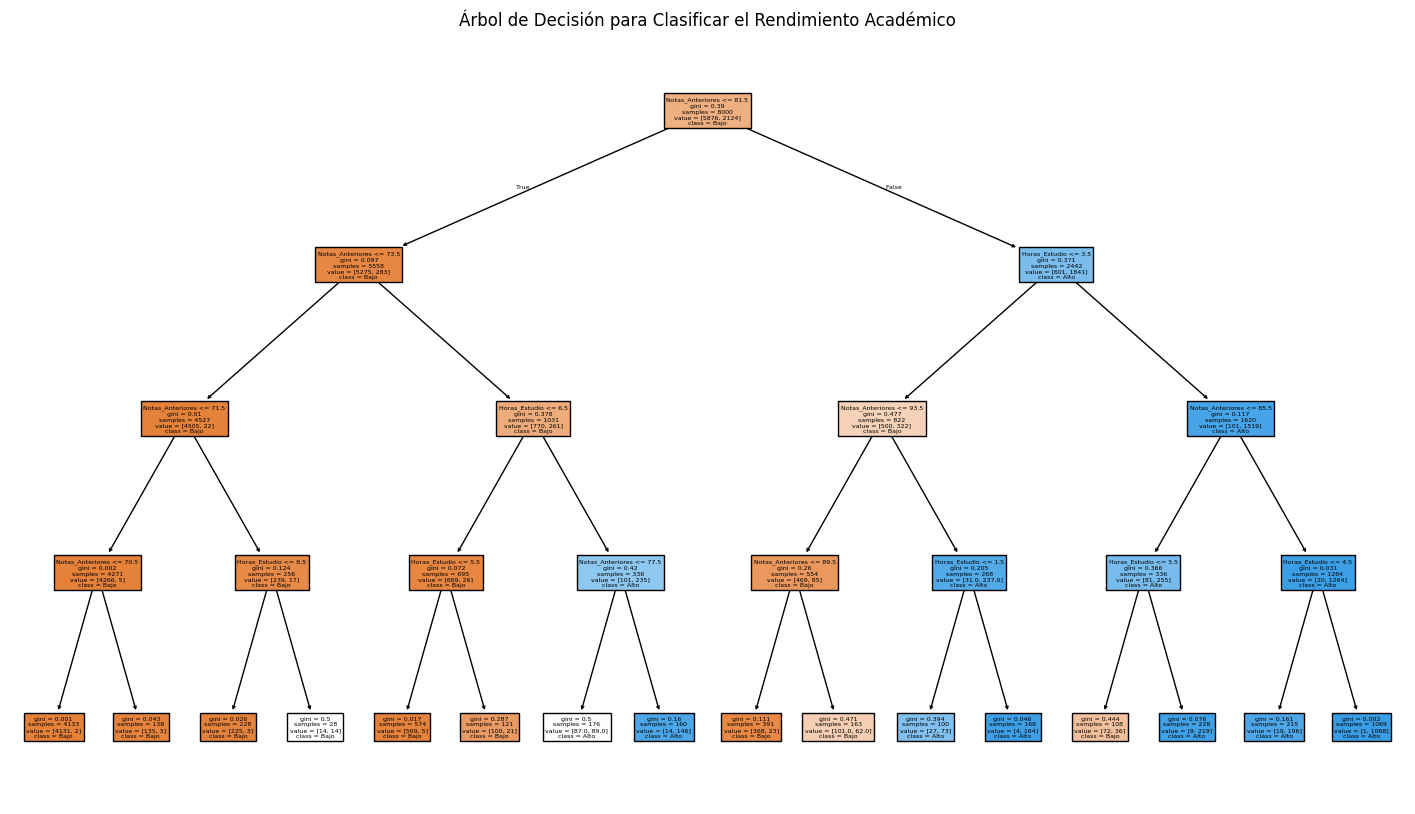

In [7]:
# Se grafica la estructura del árbol
plt.figure(figsize=(18,10))
plot_tree(modelo_arbol, feature_names=X.columns, class_names=["Bajo", "Alto"], filled=True)
plt.title("Árbol de Decisión para Clasificar el Rendimiento Académico")
plt.show()

## 7. Evaluación del rendimiento del modelo

Una vez entrenado el árbol, se evalúa su rendimiento usando:

- **Matriz de confusión**: para ver cuántas predicciones fueron correctas y cuántas fallaron
- **Reporte de clasificación**: que incluye métricas como precisión, recall y F1-score

Esto permite entender si el modelo está equilibrado o si tiende a equivocarse más en alguna clase.

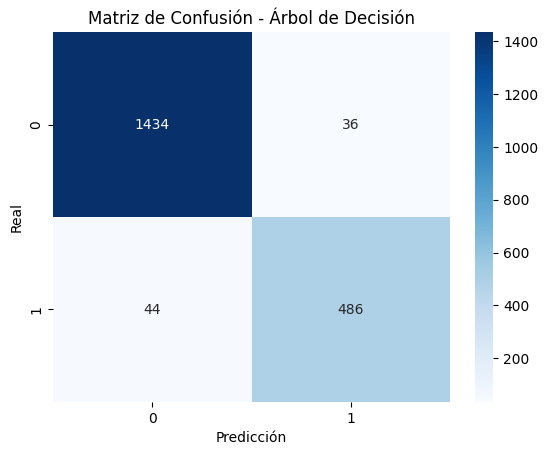

              precision    recall  f1-score   support

        Bajo       0.97      0.98      0.97      1470
        Alto       0.93      0.92      0.92       530

    accuracy                           0.96      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.96      0.96      0.96      2000



In [8]:
# Se predicen los resultados sobre el conjunto de prueba
y_pred = modelo_arbol.predict(X_test)

# Se calcula y visualiza la matriz de confusión
matriz = confusion_matrix(y_test, y_pred)
sns.heatmap(matriz, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - Árbol de Decisión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# Se imprime el reporte de clasificación
print(classification_report(y_test, y_pred, target_names=["Bajo", "Alto"]))

## 8. Conclusiones

- El modelo ha aprendido a clasificar a los estudiantes usando reglas basadas en **horas de estudio** y **notas anteriores**, que aparecen como divisiones principales en el árbol.

- Aunque no alcanza la misma precisión que modelos lineales más complejos, el árbol aporta una visión clara y lógica de cómo se llega a cada predicción.

- Este tipo de modelo se recomienda cuando se desea **explicabilidad**, por ejemplo, para justificar por qué un estudiante es considerado en riesgo o por qué se espera que tenga un alto rendimiento.


📌 Se ha obtenido una **precisión del 96%**, lo cual está bastante bien para un modelo tan interpretable.  
Tanto las clases “alto” como “bajo” se han clasificado de manera equilibrada.

---

### 📉 Comparación con la regresión lineal

| Modelo                | Accuracy / R² | Interpretabilidad | Variables más relevantes            |
|-----------------------|----------------|-------------------|-------------------------------------|
| Árbol de Decisión     | **96%**        | ⭐⭐⭐⭐⭐            | `Notas_Anteriores`, `Horas_Estudio` |
| Regresión Lineal      | **R² = 0.785** | ⭐⭐                | Todas, aunque destacan dos          |

✔️ El árbol tiene más **mayor precisión numérica** y ofrece **mucha más claridad** que la regresión simple sobre cómo se toman las decisiones.  
No solo dice “cuánto influye” una variable, sino “en qué punto exacto” marca la diferencia entre un rendimiento alto o bajo.

---

### 🎯 ¿Es un buen modelo?

- 📈 Sí. El árbol entrega predicciones con un **buen nivel de acierto (96%)** sin complicaciones(quizás demasiado alto).
- 🧠 Es **muy fácil de entender**, ideal para explicar decisiones a profesores, tutores o incluso a los estudiantes.
- 💡 Se puede seguir mejorando, por ejemplo:
  - Eliminando variables poco relevantes
  - Probando con **mayor o menor profundidad**
  - O combinándolo luego con un **Random Forest**
